In [1]:
import pickle
import numpy as np
import ZMPY3D as z
import matplotlib.pyplot as plt

In [2]:
def create_voxel_shape_adapted2(shape_type, radius=15, grid_width=1.0):
    """
    Creates a voxel grid for a simple 3D shape (sphere or cube).
    The structure loosely imitates how ZMPY3D prepares bounding boxes and fills grids.
    """

    if shape_type not in ['sphere', 'cube']:
        raise ValueError("Supported shape_types: 'sphere', 'cube'")

    # Estimate the bounding box of the shape by placing 8 extreme points around the center
    r = radius * grid_width
    center = np.array([r, r, r])

    points = [
        center + np.array([r, r, r]),
        center + np.array([r, r, -r]),
        center + np.array([r, -r, r]),
        center + np.array([r, -r, -r]),
        center + np.array([-r, r, r]),
        center + np.array([-r, r, -r]),
        center + np.array([-r, -r, r]),
        center + np.array([-r, -r, -r]),
    ]
    xyz_bbox = np.array(points)

    # Get raw min/max coordinates and convert them into voxel-space dimensions
    min_bbox_point = np.min(xyz_bbox, axis=0)
    max_bbox_point = np.max(xyz_bbox, axis=0)
    dimension_bbox_unscaled = max_bbox_point - min_bbox_point

    # Add some padding around the shape (ZMPY3D also adds extra space)
    MAX_BOX_EDGE = 4
    BOX_EDGE = 1
    aa_box = np.ones((BOX_EDGE, BOX_EDGE, BOX_EDGE))

    # Final size of the voxel grid in each dimension
    dimension_bbox_scaled = np.ceil(
        (dimension_bbox_unscaled / grid_width) + MAX_BOX_EDGE
    ).astype(int)

    # The physical coordinate of the grid corner (real-world coordinates)
    corner_xyz = min_bbox_point - MAX_BOX_EDGE * grid_width / 2

    # Prepare an empty voxel grid
    voxel_grid = np.zeros(dimension_bbox_scaled, dtype=np.float64)

    # Create a coordinate system centered inside the grid,
    # so we can easily test whether each voxel belongs to the shape
    grid_dims = dimension_bbox_scaled
    z_idx, y_idx, x_idx = np.ogrid[:grid_dims[0], :grid_dims[1], :grid_dims[2]]
    grid_center_voxels = grid_dims // 2

    x_centered = x_idx - grid_center_voxels[0]
    y_centered = y_idx - grid_center_voxels[1]
    z_centered = z_idx - grid_center_voxels[2]

    R_voxels = radius

    # Build a simple mask marking which voxel centers lie inside the shape
    if shape_type == 'sphere':
        mask = x_centered**2 + y_centered**2 + z_centered**2 <= R_voxels**2
    else:  # cube
        # Slight scaling so the cube doesn't look too "fat"
        R_cube = R_voxels / 1.5
        mask = (
                (np.abs(x_centered) <= R_cube) &
                (np.abs(y_centered) <= R_cube) &
                (np.abs(z_centered) <= R_cube)
        )

    # Convert mask indices into actual 3D coordinates
    positions = np.where(mask)
    xyz = np.zeros((len(positions[0]), 3))
    for i in range(len(positions[0])):
        z, y, x = positions[0][i], positions[1][i], positions[2][i]
        # Real-world coordinate of the voxel center
        coord = corner_xyz + np.array([z, y, x]) * grid_width + grid_width / 2.0
        xyz[i] = coord

    # Add a tiny 1×1×1 "box" at each voxel belonging to the shape
    # (this mirrors the original loop where each atom adds its own box)
    num_of_atom = xyz.shape[0]
    weight_multiplier = 1.0

    for i in range(num_of_atom):
        coord = xyz[i, :]

        box_edge = aa_box.shape[0]
        # Convert real coordinate to grid index where the box should start
        coord_box_corner = np.fix(
            np.round((coord - corner_xyz) / grid_width - box_edge / 2)
        ).astype(int)

        start = coord_box_corner
        end = coord_box_corner + box_edge

        # Fill the voxel
        voxel_grid[start[0]:end[0], start[1]:end[1], start[2]:end[2]] += \
            aa_box * weight_multiplier

    return voxel_grid, corner_xyz


In [3]:
# 1. LOAD ZMPY3D MATH CORE

MaxOrder = 20  # Polynomial order (higher = more detail, but slower)

# Paths to cache files inside the ZMPY3D package
BinomialCacheFilePath = z.__file__.replace('__init__.py', 'cache_data') + '/BinomialCache.pkl'
LogCacheFilePath = z.__file__.replace(
    '__init__.py',
    'cache_data'
) + '/LogG_CLMCache_MaxOrder{:02d}.pkl'.format(MaxOrder)

# Load precomputed binomial coefficients and G/CLM caches
with open(BinomialCacheFilePath, 'rb') as file:
    BinomialCachePKL = pickle.load(file)
with open(LogCacheFilePath, 'rb') as file:
    CachePKL = pickle.load(file)

# Unpack useful pieces from the cache dicts
BinomialCache = BinomialCachePKL['BinomialCache']
GCache_pqr_linear = CachePKL['GCache_pqr_linear']
GCache_complex = CachePKL['GCache_complex']
GCache_complex_index = CachePKL['GCache_complex_index']
CLMCache3D = CachePKL['CLMCache3D']
CLMCache = CachePKL['CLMCache']
RotationIndex = CachePKL['RotationIndex']

# Global parameters and precomputed Gaussian boxes for residues
Param = z.get_global_parameter()
ResidueBox = z.get_residue_gaussian_density_cache(Param)

# Indices used for building rotation matrices / rotation-related structures
s_id = np.squeeze(RotationIndex['s_id'][0, 0]) - 1
n = np.squeeze(RotationIndex['n'][0, 0])
l = np.squeeze(RotationIndex['l'][0, 0])
m = np.squeeze(RotationIndex['m'][0, 0])
mu = np.squeeze(RotationIndex['mu'][0, 0])
k = np.squeeze(RotationIndex['k'][0, 0])
IsNLM_Value = np.squeeze(RotationIndex['IsNLM_Value'][0, 0]) - 1


In [4]:
def OneTimeConversion(Voxel3D, Corner, GridWidth):
    """
    Takes a voxel grid and returns its Zernike descriptors.
    Uses the global ZMPY3D caches loaded earlier.
    """
    Dimension_BBox_scaled = Voxel3D.shape

    # Build simple sample grids for X/Y/Z indices
    XYZ_SampleStruct = {
        'X_sample': np.arange(Dimension_BBox_scaled[0] + 1),
        'Y_sample': np.arange(Dimension_BBox_scaled[1] + 1),
        'Z_sample': np.arange(Dimension_BBox_scaled[2] + 1)
    }

    # Compute the total mass and center of the voxelized object
    VolumeMass, Center, _ = z.calculate_bbox_moment(Voxel3D, 1, XYZ_SampleStruct)

    # Estimate the average distance from the center (used as an effective radius)
    AverageVoxelDist2Center, _ = z.calculate_molecular_radius(
        Voxel3D, Center, VolumeMass, Param['default_radius_multiplier']
    )

    # Convert center from voxel units to real coordinates
    Center_scaled = Center * GridWidth + Corner

    # Rebuild sampling grid around the object’s center and radius
    SphereXYZ_SampleStruct = z.get_bbox_moment_xyz_sample(
        Center, AverageVoxelDist2Center, Dimension_BBox_scaled
    )

    # Compute bounding-box moments in this new coordinate system
    _, _, SphereBBoxMoment = z.calculate_bbox_moment(
        Voxel3D, MaxOrder, SphereXYZ_SampleStruct
    )

    # Convert these raw moments into Zernike moment coefficients
    _, ZMoment_raw = z.calculate_bbox_moment_2_zm(
        MaxOrder,
        GCache_complex,
        GCache_pqr_linear,
        GCache_complex_index,
        CLMCache3D,
        SphereBBoxMoment
    )

    # Generate A/B rotation parameters for several normalization orders
    ABList_all_parts = []
    for order in range(2, 7):  # orders 2–6
        ABList_all_parts.append(z.calculate_ab_rotation_all(ZMoment_raw, order))

    ABList_all = np.vstack(sum(ABList_all_parts, []))

    # Build the final Zernike descriptors using rotation-invariant combinations
    ZMList_all = z.calculate_zm_by_ab_rotation(
        ZMoment_raw,
        BinomialCache,
        ABList_all,
        MaxOrder,
        CLMCache,
        s_id, n, l, m, mu, k, IsNLM_Value
    )

    # Stack and reshape to final descriptor format
    ZMList_all = np.stack(ZMList_all, axis=3)
    ZMList_all = np.transpose(ZMList_all, (2, 1, 0, 3))
    ZMList_all = ZMList_all[~np.isnan(ZMList_all)]
    ZMList_all = np.reshape(ZMList_all, (np.int64(ZMList_all.size / 320), 320))

    return ZMList_all


In [5]:
# Generate voxel grids for the test shapes
voxel_sphere, corner_sphere = create_voxel_shape_adapted2('sphere')
voxel_cube, corner_cube = create_voxel_shape_adapted2('cube')

# Print voxel grid information
print(f"Voxel grid size (sphere): {voxel_sphere.shape}")
print(f"Corner XYZ (sphere offset): {corner_sphere}")
print(f"Voxel grid size (cube): {voxel_cube.shape}")
print(f"Corner XYZ (cube offset): {corner_cube}")


Voxel grid size (sphere): (34, 34, 34)
Corner XYZ (sphere offset): [-2. -2. -2.]
Voxel grid size (cube): (34, 34, 34)
Corner XYZ (cube offset): [-2. -2. -2.]


In [6]:
zm_sphere = OneTimeConversion(voxel_sphere, corner_sphere, 1.0)
zm_cube = OneTimeConversion(voxel_cube, corner_cube,  1.0)

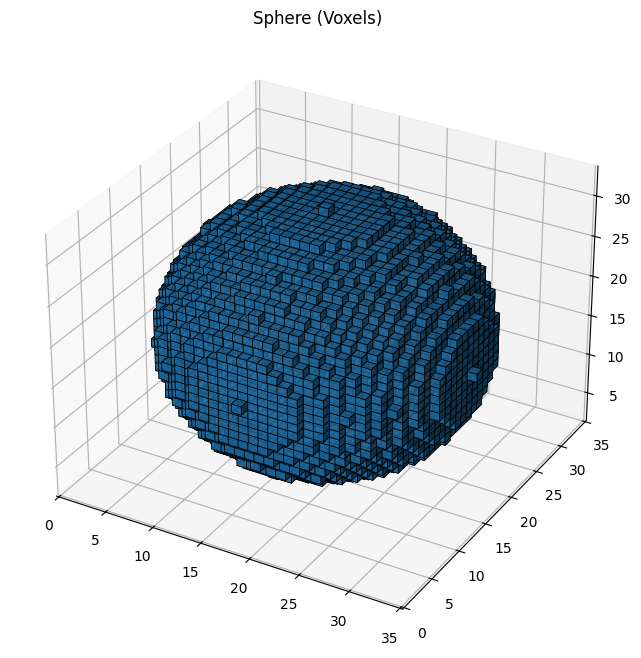

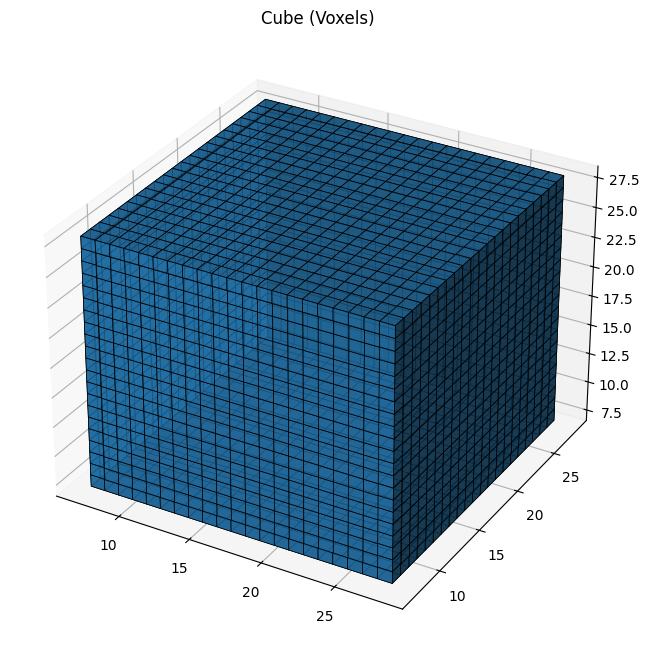

In [7]:
def plot_voxels(voxel_data, title="Voxel Shape"):
    """Draws a 3D voxel visualization."""
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot only voxels where value > 0
    ax.voxels(voxel_data > 0, edgecolor='k', linewidth=0.5, alpha=0.8)

    ax.set_title(title)
    plt.show()

# Test visualization
plot_voxels(voxel_sphere, "Sphere (Voxels)")
plot_voxels(voxel_cube, "Cube (Voxels)")


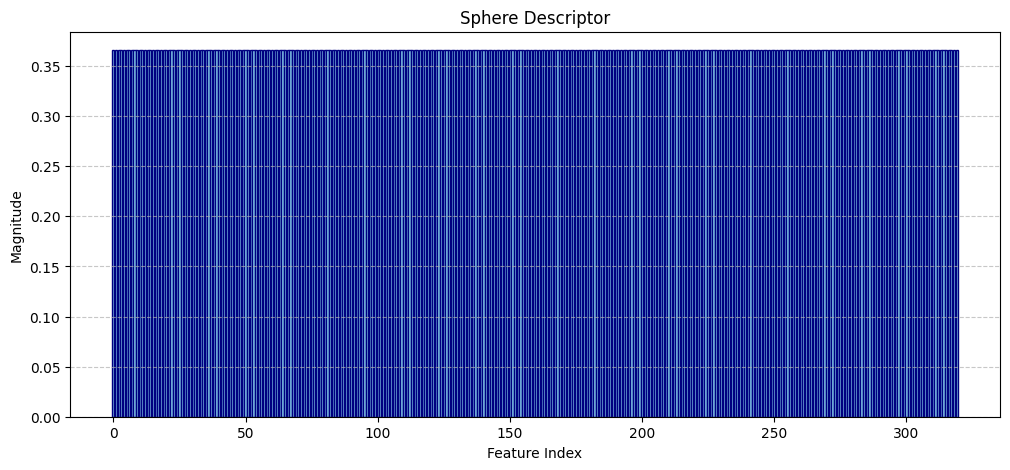

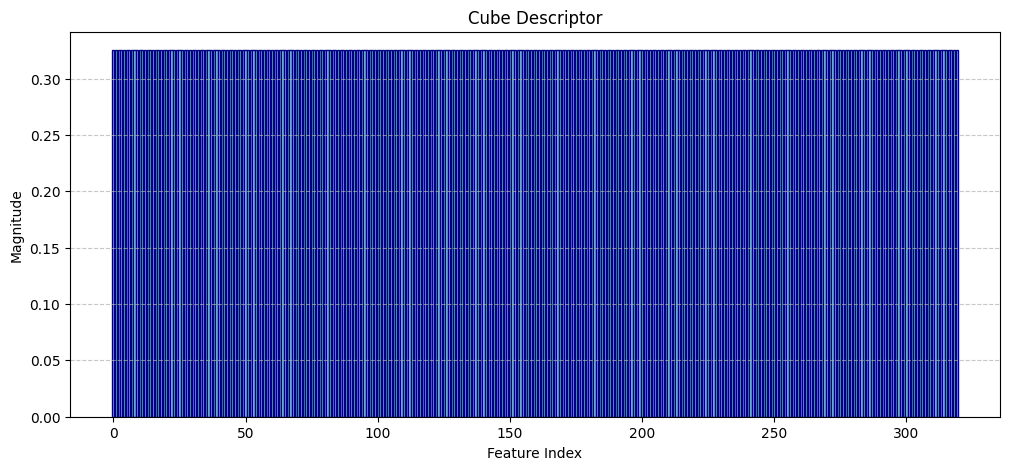

In [8]:
def plot_zernike_fingerprint(zm_vector, title="Zernike Descriptor"):
    """
    Visualizes a Zernike descriptor as a bar chart.
    zm_vector: a 1D array (one row returned by OneTimeConversion).
    """
    # Take absolute values since Zernike moments can be complex
    y_values = np.abs(zm_vector)
    x_values = np.arange(len(y_values))

    plt.figure(figsize=(12, 5))
    plt.bar(x_values, y_values, color='skyblue', edgecolor='navy')
    plt.xlabel("Feature Index")
    plt.ylabel("Magnitude")
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# The Zernike output usually contains several rotation-normalized variants.
# Often the first one is used, or the one that achieves the best alignment score.
# Here we simply plot the first available descriptor row [0, :].
if zm_sphere.size > 0:
    plot_zernike_fingerprint(zm_sphere[0], "Sphere Descriptor")

if zm_cube.size > 0:
    plot_zernike_fingerprint(zm_cube[0], "Cube Descriptor")


In [9]:
def gaussian_3d(size=5, sigma=1.0):
    """
    Generates a 3D Gaussian array of shape (size x size x size).
    Normalized so that the center value is 1.0 (similar to atomic density).
    """
    ax = np.linspace(-(size // 2), size // 2, size)
    z, y, x = np.meshgrid(ax, ax, ax)
    gauss = np.exp(-(x**2 + y**2 + z**2) / (2 * sigma**2))
    return gauss / np.max(gauss)


def create_voxel_shape_adapted(shape_type, radius=15, grid_width=1.0):
    """
    Creates a voxel grid for simple shapes (sphere/cube) using boundary and padding
    logic similar to ZMPY3D. To approximate the original behavior, we generate
    “fake atoms” inside the shape and fill the grid by adding small Gaussian
    boxes at their positions.
    """

    if shape_type not in ['sphere', 'cube']:
        raise ValueError("Supported shape_types: 'sphere', 'cube'")

    # === PDB-LIKE BOUNDING BOX LOGIC ===

    # 1. Define “atoms” used only to estimate the shape boundaries (e.g. 8 cube corners)
    r = radius * grid_width  # Radius in real units
    center = np.array([r, r, r])  # Shape center in real coordinates

    # Create 8 extreme points that describe the minimal/maximal extent of the shape
    points = [
        center + np.array([r, r, r]),
        center + np.array([r, r, -r]),
        center + np.array([r, -r, r]),
        center + np.array([r, -r, -r]),
        center + np.array([-r, r, r]),
        center + np.array([-r, r, -r]),
        center + np.array([-r, -r, r]),
        center + np.array([-r, -r, -r]),
    ]
    xyz_bbox = np.array(points)

    min_bbox_point = np.min(xyz_bbox, axis=0)
    max_bbox_point = np.max(xyz_bbox, axis=0)
    dimension_bbox_unscaled = max_bbox_point - min_bbox_point

    # 2. Set padding (similar to max_box_edge in the original code)
    # Here we use a 5x5x5 Gaussian box (typical for ZMPY3D-style densities)
    BOX_EDGE = 5  # Box size (odd for symmetry)
    MAX_BOX_EDGE = BOX_EDGE  # Single box type, so max = BOX_EDGE
    aa_box = gaussian_3d(size=BOX_EDGE, sigma=1.0)  # Gaussian box

    # 3. Compute final voxel grid dimensions
    dimension_bbox_scaled = np.ceil(
        (dimension_bbox_unscaled / grid_width) + MAX_BOX_EDGE
    ).astype(int)

    # 4. Compute the corner of the grid in real coordinates
    corner_xyz = min_bbox_point - MAX_BOX_EDGE * grid_width / 2

    # 5. Initialize the voxel grid
    voxel_grid = np.zeros(dimension_bbox_scaled, dtype=np.float64)

    # === GENERATE FAKE ATOMS INSIDE THE SHAPE ===
    # Build a mask that marks which voxel centers lie inside the shape
    grid_dims = dimension_bbox_scaled
    z_idx, y_idx, x_idx = np.ogrid[:grid_dims[0], :grid_dims[1], :grid_dims[2]]
    grid_center_voxels = grid_dims // 2

    x_centered = x_idx - grid_center_voxels[0]
    y_centered = y_idx - grid_center_voxels[1]
    z_centered = z_idx - grid_center_voxels[2]

    # Radius in voxel units
    R_voxels = radius

    mask = None
    if shape_type == 'sphere':
        mask = x_centered**2 + y_centered**2 + z_centered**2 <= R_voxels**2
    elif shape_type == 'cube':
        # Slightly shrink the cube to avoid numerical issues in Zernike calculations
        R_cube = R_voxels / 1.5
        mask = (
                (np.abs(x_centered) <= R_cube) &
                (np.abs(y_centered) <= R_cube) &
                (np.abs(z_centered) <= R_cube)
        )

    # Get indices of the mask and convert them to real coordinates (voxel centers)
    positions = np.where(mask)
    xyz = np.zeros((len(positions[0]), 3))
    for i in range(len(positions[0])):
        z, y, x = positions[0][i], positions[1][i], positions[2][i]
        coord = corner_xyz + np.array([z, y, x]) * grid_width + grid_width / 2.0
        xyz[i] = coord

    # === FILL THE GRID (ORIGINAL BOX-ADDING LOOP) ===
    # We simulate a single “atom type”, no weight map, multiplier = 1
    num_of_atom = xyz.shape[0]
    weight_multiplier = 1.0

    for i in range(num_of_atom):
        coord = xyz[i, :]

        # aa_box and box_edge are fixed
        box_edge = aa_box.shape[0]

        coord_box_corner = np.fix(
            np.round((coord - corner_xyz) / grid_width - box_edge / 2)
        ).astype(int)

        start = coord_box_corner
        end = coord_box_corner + box_edge

        # Check bounds to avoid indexing errors
        if (start >= 0).all() and (end <= voxel_grid.shape).all():
            voxel_grid[start[0]:end[0], start[1]:end[1], start[2]:end[2]] += \
                aa_box * weight_multiplier
        else:
            # If the box goes out of bounds, we skip it (could be clipped instead)
            pass  # Or implement clipping logic here if needed

    return voxel_grid, corner_xyz
